In [1]:
%load_ext autoreload
%autoreload 2

from bethe_block import *
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
# from scipy.constants import pi, epsilon_0, m_p, N_A, m_u, elementary_charge, kilo, centi, speed_of_light, eV, mega, milli, gram, physical_constants, e

In [2]:
rho = 2.69
ke = np.logspace(-3, 4, 400) # in MeV
pstar_data = np.genfromtxt('pstar_27Al.dat', skip_header=8)
wiki_data = np.array([[.3, 100],[70, 2]])
# bse = bethe_bloch(ke, Z=13, A=27, rho=rho, I=166e-6, relativistic=False) / 10  # in MeV/mm
bse = bethe_bloch(ke, Z=13, A=27, rho=rho, I=166e-6)  # in MeV/mm
alcorr = bethe_bloch_aluminum_semicorrected(ke)
sp = stoping_power(ke, Z=13, A=27, rho=rho, I=166e-6)

Text(0.5, 0.98, 'Aluminium stoping power for protons')

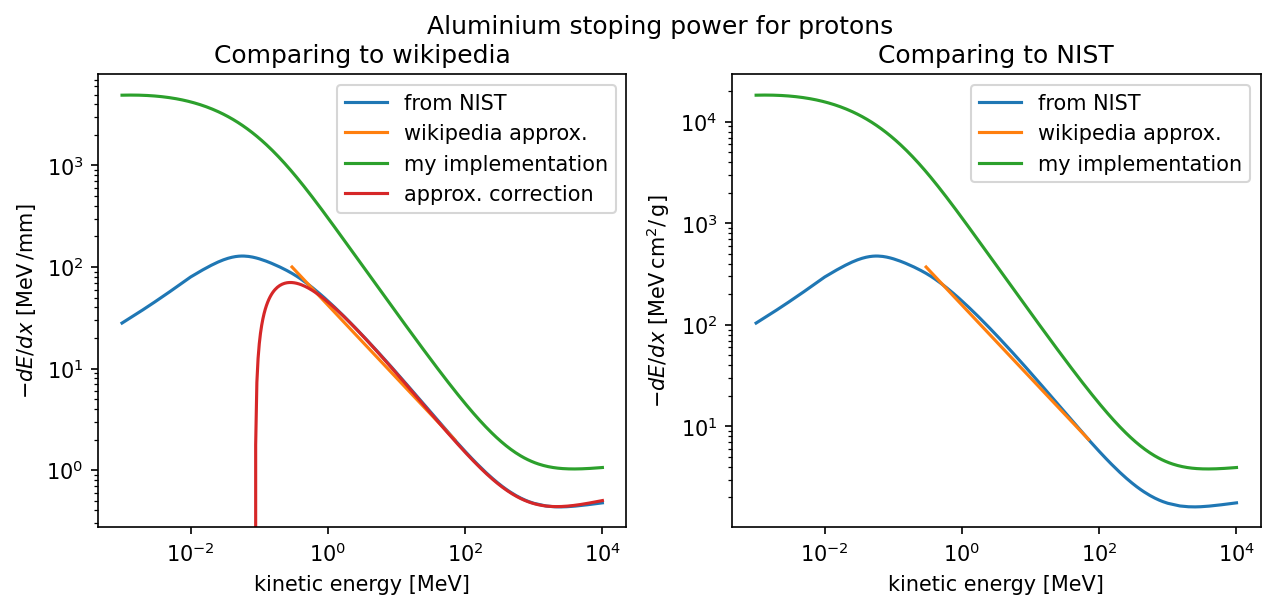

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
# for beryllium


plt.sca(ax1)

plt.plot(pstar_data[:, 0], pstar_data[:, 3] * rho / 10, label='from NIST')
plt.plot(wiki_data[:, 0], wiki_data[:, 1], label='wikipedia approx.')
plt.plot(ke, bse, label='my implementation')
plt.plot(ke, alcorr, label='approx. correction')

plt.loglog()
plt.xlabel('kinetic energy [MeV]')
plt.ylabel(r'$-dE/dx$ $\rm [MeV\,/mm]$')
plt.title('Comparing to wikipedia')
plt.legend()

plt.sca(ax2)

plt.plot(pstar_data[:, 0], pstar_data[:, 3], label='from NIST')
plt.plot(wiki_data[:, 0], wiki_data[:, 1]*10/rho, label='wikipedia approx.')
plt.plot(ke, sp*10, label='my implementation')

plt.loglog()
plt.xlabel('kinetic energy [MeV]')
plt.ylabel(r'$-dE/dx$ $\rm [MeV\,cm^2/\,g ]$')
plt.title('Comparing to NIST')
plt.legend()

f.suptitle('Aluminium stoping power for protons')

The differences between the implementation and the values from NIST and wikipedia come from the shell corrections, which are not included in my implementation. 

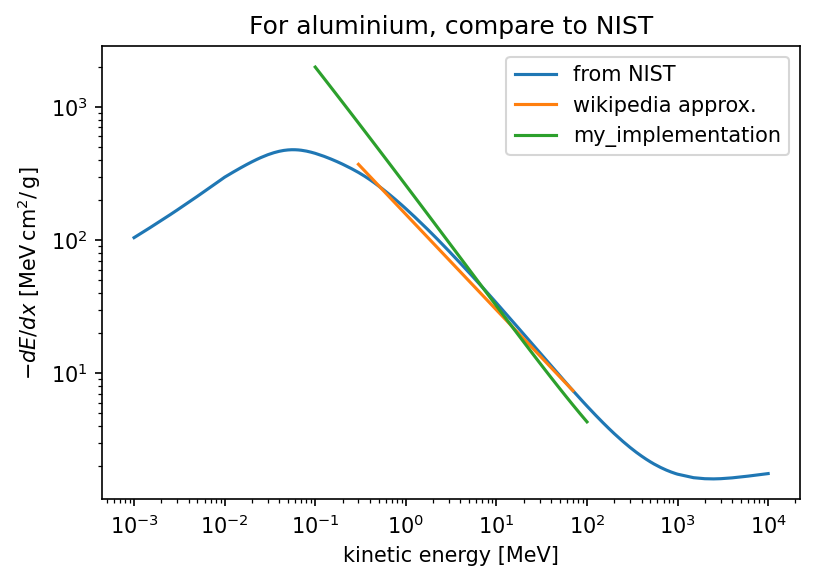

In [15]:
plt.subplots(dpi=150)

ke = np.logspace(-1, 2, 40)

plt.plot(pstar_data[:, 0], pstar_data[:, 3], label='from NIST')

plt.plot(wiki_data[:, 0], wiki_data[:, 1]*10/2.7, label='wikipedia approx.')


sp = stoping_power(ke, Z=13, A=27, rho=2.69, I=166e-6)
plt.plot(ke, sp*4, label='my_implementation')


plt.loglog()
plt.xlabel('kinetic energy [MeV]')
plt.ylabel(r'$-dE/dx$ $\rm [MeV\,cm^2/\,g ]$')
plt.title('For aluminium, compare to NIST')
plt.legend()

---
## Computing stopping power and range from relative relations

16.076523547893373

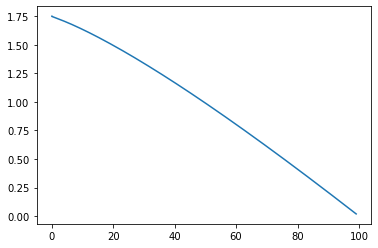

In [3]:
spower = lambda en, Z, A, r: np.interp(en, pstar_data[:, 0], pstar_data[:, 3] * Z/A * 26/13 * r / 10)
full_range = lambda en, Z, A, r: np.interp(en, pstar_data[:, 0], pstar_data[:, 4] * A/Z * 13/26 / r * 10)

def prange(e0, Z, A, r):
    
    if e0 > pstar_data[-1, 0]:
        print('ERROR: The starting energy is larger than the maximum in the grid.')
        return
    
    dlog_en = np.log10(e0)-np.log10(pstar_data[0, 0])
    log_en = np.linspace(np.log10(e0), np.log10(pstar_data[0, 0]), int(dlog_en*250)) # log space
    
    sp = spower(10**log_en, Z, A, r)
    pr = np.trapz(-10**log_en/sp, log_en)
    pr2 = np.trapz(1/sp, 10**log_en)
    
#     plt.loglog(10**log_en, sp)
    plt.plot(10**log_en[1:], cumtrapz(-np.exp(log_en)/sp, log_en))
    
    return pr

prange(100, 13, 26, 2.7)

In [56]:
Ep = 10
print('range in 27Al in um', 1e3*full_range(Ep, 13, 27, 2.7))
print('range in  6Li in um', 1e3*full_range(Ep, 3, 6, .46))
print('range in  7Li in um', 1e3*full_range(Ep, 3, 6, .537))
print('range in  11B in um', 1e3*full_range(Ep, 5, 11, 2.47))
print('testing equivalence: ', full_range(Ep, 5, 11, 2.47) - full_range(Ep, 3, 6, .46) * (11./6 * .46/2.47 * 3/5) )

range in 27Al in um 655.7692307692308
range in  6Li in um 3706.5217391304354
range in  7Li in um 3175.0465549348237
range in  11B in um 759.3117408906882
testing equivalence:  -2.220446049250313e-16


---

In [37]:
def prange(Eo, **kwargs):
    """calculates the range of a proton of energy Eo
    in a  material. Uses the bethe-bloch formula
    
    Eo in MeV
    """
    logEcut = np.max([np.log10(Eo) - 3, -3])
    E = np.logspace(logEcut, np.log10(Eo), 10*int(np.log10(Eo) - logEcut))
    
    SP = bethe_bloch(E, **kwargs)
    
    return E[1:], cumtrapz(1./SP, E)

Text(0.5, 1.0, 'Proton ranges for Aluminum')

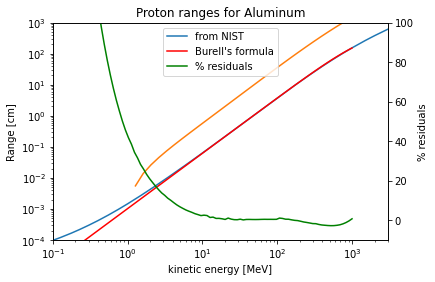

In [5]:
plt.plot(pstar_data[:, 0], pstar_data[:, 4] / rho, label='from NIST')

# plt.loglog(*prange(1000), label='my implementation')

egrid, bprange = burells_formula(np.logspace(-1, 3, 100), 'aluminum')
plt.loglog(egrid, bprange/rho, 'r', label='Burell\'s formula')
plt.loglog(*CE_range(1e3, 13, 27, 2.7))

nprange = np.interp(egrid, pstar_data[:, 0], pstar_data[:, 4])

ax1 = plt.gca()
ax2 = plt.twinx()

ax2.plot(egrid, (nprange - bprange)/bprange*100, 'g', label='% residuals')
# x = np.logspace(-5, 2, 40)
# plt.scatter(x, x**1.8)

plt.ylabel('% residuals')
plt.ylim(-10, 100)

plt.sca(ax1)
plt.plot([], [], 'g', label='% residuals')
plt.xlabel('kinetic energy [MeV]')
plt.ylabel('Range [cm]')

plt.axis([1e-1, 3e3, 1e-4, 1e3])
plt.legend(loc='upper center')

plt.title('Proton ranges for Aluminum')

(1.0, 10.0, 0.0, 0.6)

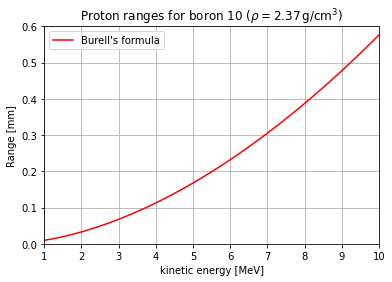

In [8]:

# plt.plot(pstar_data[:, 0], pstar_data[:, 4] / rho, label='from NIST')

egrid, bprange = burells_formula(np.linspace(.1, 10, 100), (5, 10))
plt.plot(egrid, 10*bprange/2.37, 'r', label='Burell\'s formula')

plt.xlabel('kinetic energy [MeV]')
plt.ylabel('Range [mm]')

plt.grid()
plt.legend()
plt.title(r'Proton ranges for boron 10 ($\rho=2.37 \, {\rm g/cm^3}$)')

plt.axis([1, 10, 0, .6])